In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# === Config ===
noise_dim = 100
batch_size = 256
lr = 1e-4
num_epochs = 500
lambda_gp = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# === Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/CIC-IDS-2017/final_cgan_ready_scaled.csv")
X = df.drop("Label", axis=1).values.astype(np.float32)
y = df["Label"].values.astype(int)
feature_dim = X.shape[1]
num_classes = len(np.unique(y))

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# === Generator ===
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z, labels):
        return self.model(torch.cat((z, labels), dim=1))

# === Discriminator ===
class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x, labels):
        return self.model(torch.cat((x, labels), dim=1))

# === Gradient Penalty ===
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# === Init Models & Optimisers ===
G = Generator(noise_dim, num_classes, feature_dim).to(device)
D = Discriminator(feature_dim, num_classes).to(device)
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.9))

# === Training ===
n_critic = 5
for epoch in range(num_epochs):
    for i, (real_data, real_labels) in enumerate(loader):
        real_data = real_data.to(device)
        real_labels = real_labels.to(device)
        real_labels_oh = F.one_hot(real_labels, num_classes).float().to(device)

        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim, device=device)
            fake_data = G(z, real_labels_oh).detach()

            d_real = D(real_data, real_labels_oh)
            d_fake = D(fake_data, real_labels_oh)

            gradient_penalty = compute_gradient_penalty(D, real_data.data, fake_data.data, real_labels_oh)
            d_loss = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gradient_penalty

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_data = G(z, real_labels_oh)
        d_fake = D(fake_data, real_labels_oh)
        g_loss = -torch.mean(d_fake)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# === Save Trained Models ===
G_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt2_generator.pth"
D_path = "/content/drive/MyDrive/CIC-IDS-2017/models/attempt2_discriminator.pth"
os.makedirs(os.path.dirname(G_path), exist_ok=True)
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)
print("💾 Attempt 2 models saved to Google Drive")

✅ Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/500] | D Loss: -0.9207 | G Loss: 0.6762
Epoch [10/500] | D Loss: -0.5827 | G Loss: 1.0041
Epoch [20/500] | D Loss: -0.3381 | G Loss: 2.3090
Epoch [30/500] | D Loss: -0.2661 | G Loss: 2.7525
Epoch [40/500] | D Loss: -0.2059 | G Loss: 2.6645
Epoch [50/500] | D Loss: -0.1295 | G Loss: 2.1925
Epoch [60/500] | D Loss: -0.1453 | G Loss: 2.0566
Epoch [70/500] | D Loss: -0.0905 | G Loss: 1.5215
Epoch [80/500] | D Loss: -0.1159 | G Loss: 1.1414
Epoch [90/500] | D Loss: -0.1059 | G Loss: 1.0167
Epoch [100/500] | D Loss: -0.0901 | G Loss: 1.0070
Epoch [110/500] | D Loss: -0.1038 | G Loss: 0.9112
Epoch [120/500] | D Loss: -0.1000 | G Loss: 0.8576
Epoch [130/500] | D Loss: -0.1120 | G Loss: 0.6804
Epoch [140/500] | D Loss: -0.1037 | G Loss: 0.8347
Epoch [150/500] | D Loss: -0.0707 | G Loss: 0.5668
Epoch [160/500] | D Loss: -0.0844 | G Loss: 0.5539
Epoch [170/500] | D Loss: -0.0825 | G Loss: 0.5916
Epoch [180/500] | D Loss: -0.0691 | G Loss: 0.7566
Epoch [190/500] | D Loss: -0.0537 | G Loss

🔍 Step 1: Visualising t-SNE & PCA...


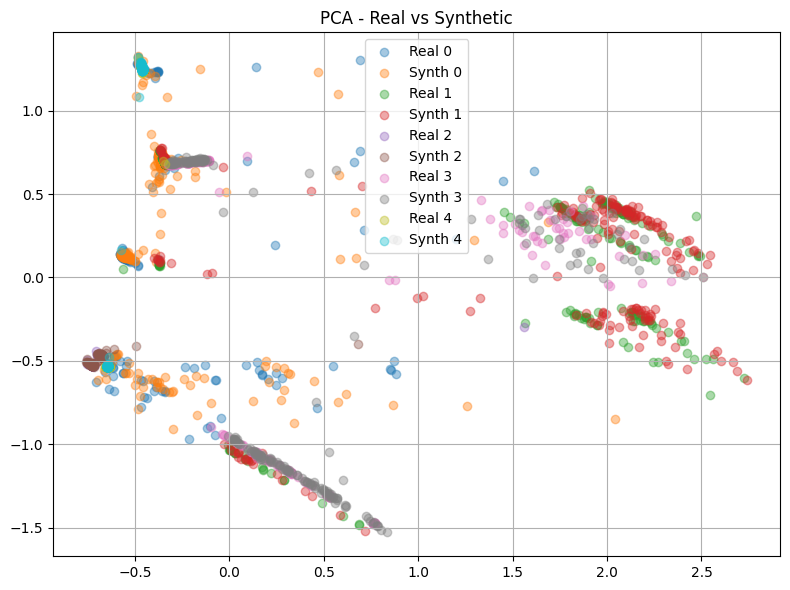

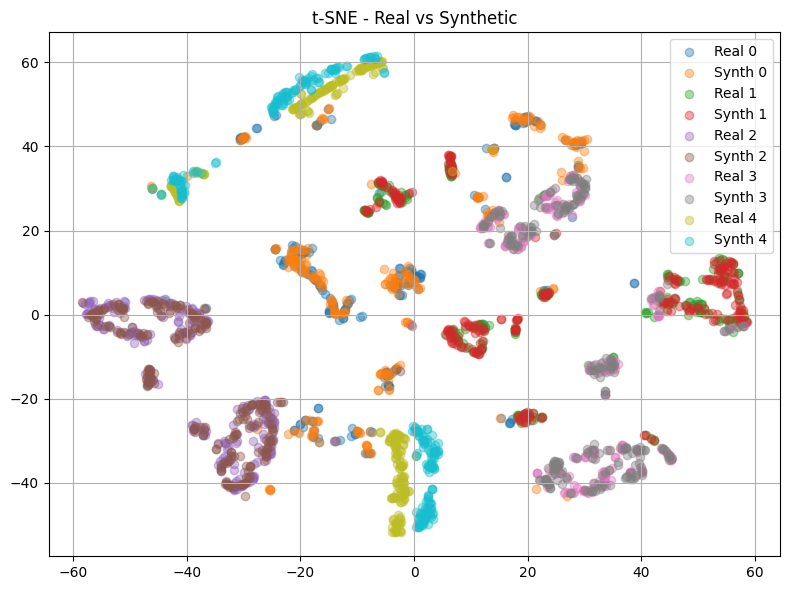

📐 Step 2: Silhouette & μ-distance...
Class 0 → Silhouette: 0.0028 | Δμ: 0.1799
Class 1 → Silhouette: 0.0004 | Δμ: 0.1406
Class 2 → Silhouette: 0.0006 | Δμ: 0.0324
Class 3 → Silhouette: -0.0023 | Δμ: 0.0281
Class 4 → Silhouette: -0.0004 | Δμ: 0.0405
📊 Step 3: F1 Score (Real vs Augmented)...
F1 (Real only):     0.9987
F1 (Real+Synth):    0.9987
🧪 Step 4: Binary Classifier Accuracy...
Binary Classifier Accuracy (Real vs Fake): 0.6363


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch

# === Sampling Function ===
def generate_samples(G, class_id, n_samples=500):
    G.eval()
    z = torch.randn(n_samples, noise_dim, device=device)
    labels = torch.full((n_samples,), class_id, dtype=torch.long, device=device)
    onehot = F.one_hot(labels, num_classes).float()
    with torch.no_grad():
        generated = G(z, onehot).cpu().numpy()
    return generated

# === Extract real data ===
X = df.drop("Label", axis=1).values
y = df["Label"].values
X_real = {i: df[df["Label"] == i].drop("Label", axis=1).values for i in range(num_classes)}

# === 1. PCA & t-SNE Visualisation ===
def visualise_tsne_pca(G):
    samples_synth = np.vstack([generate_samples(G, i, 250) for i in range(num_classes)])
    labels_synth = np.hstack([[i] * 250 for i in range(num_classes)])
    samples_real = np.vstack([X_real[i][:250] for i in range(num_classes)])
    labels_real = np.hstack([[i] * 250 for i in range(num_classes)])

    X_comb = np.vstack([samples_real, samples_synth])
    y_comb = np.hstack([labels_real, labels_synth + num_classes])  # separate classes visually

    for method, name in [(PCA(n_components=2), "PCA"), (TSNE(n_components=2, perplexity=30, random_state=42), "t-SNE")]:
        X_proj = method.fit_transform(X_comb)
        plt.figure(figsize=(8, 6))
        for class_id in np.unique(labels_real):
            plt.scatter(X_proj[y_comb == class_id, 0], X_proj[y_comb == class_id, 1], label=f"Real {class_id}", alpha=0.4)
            plt.scatter(X_proj[y_comb == class_id + num_classes, 0], X_proj[y_comb == class_id + num_classes, 1], label=f"Synth {class_id}", alpha=0.4)
        plt.title(f"{name} - Real vs Synthetic")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# === 2. Silhouette Score and μ-distance ===
def silhouette_and_mu(G):
    for class_id in range(num_classes):
        real = X_real[class_id][:300]
        fake = generate_samples(G, class_id, 300)
        combined = np.vstack([real, fake])
        labels = np.array([0]*len(real) + [1]*len(fake))
        sil_score = silhouette_score(combined, labels)
        mu_distance = np.linalg.norm(real.mean(axis=0) - fake.mean(axis=0))
        print(f"Class {class_id} → Silhouette: {sil_score:.4f} | Δμ: {mu_distance:.4f}")

# === 3. F1 Score Real vs Real+Synth ===
def f1_real_vs_augmented(G):
    clf = RandomForestClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    clf.fit(X_train, y_train)
    f1_real = f1_score(y_test, clf.predict(X_test), average="macro")

    X_synth = np.vstack([generate_samples(G, i, 1000) for i in range(num_classes)])
    y_synth = np.hstack([[i]*1000 for i in range(num_classes)])
    X_train_aug = np.vstack([X_train, X_synth])
    y_train_aug = np.hstack([y_train, y_synth])

    clf_aug = RandomForestClassifier()
    clf_aug.fit(X_train_aug, y_train_aug)
    f1_aug = f1_score(y_test, clf_aug.predict(X_test), average="macro")

    print(f"F1 (Real only):     {f1_real:.4f}")
    print(f"F1 (Real+Synth):    {f1_aug:.4f}")
    return f1_real, f1_aug

# === 4. Binary Real vs Fake Classifier ===
def binary_accuracy(G):
    real = np.vstack([X_real[i][:300] for i in range(num_classes)])
    fake = np.vstack([generate_samples(G, i, 300) for i in range(num_classes)])
    X_comb = np.vstack([real, fake])
    y_comb = np.array([0]*len(real) + [1]*len(fake))

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_comb, y_comb)
    acc = clf.score(X_comb, y_comb)
    print(f"Binary Classifier Accuracy (Real vs Fake): {acc:.4f}")
    return acc

# === Final Evaluation Runner ===
def run_full_evaluation(G):
    print("🔍 Step 1: Visualising t-SNE & PCA...")
    visualise_tsne_pca(G)

    print("📐 Step 2: Silhouette & μ-distance...")
    silhouette_and_mu(G)

    print("📊 Step 3: F1 Score (Real vs Augmented)...")
    f1_real, f1_aug = f1_real_vs_augmented(G)

    print("🧪 Step 4: Binary Classifier Accuracy...")
    acc_bin = binary_accuracy(G)

    return {
        "F1_Real": round(f1_real, 4),
        "F1_Augmented": round(f1_aug, 4),
        "Binary_Accuracy": round(acc_bin, 4)
    }

# === Run Evaluation ===
results = run_full_evaluation(G)

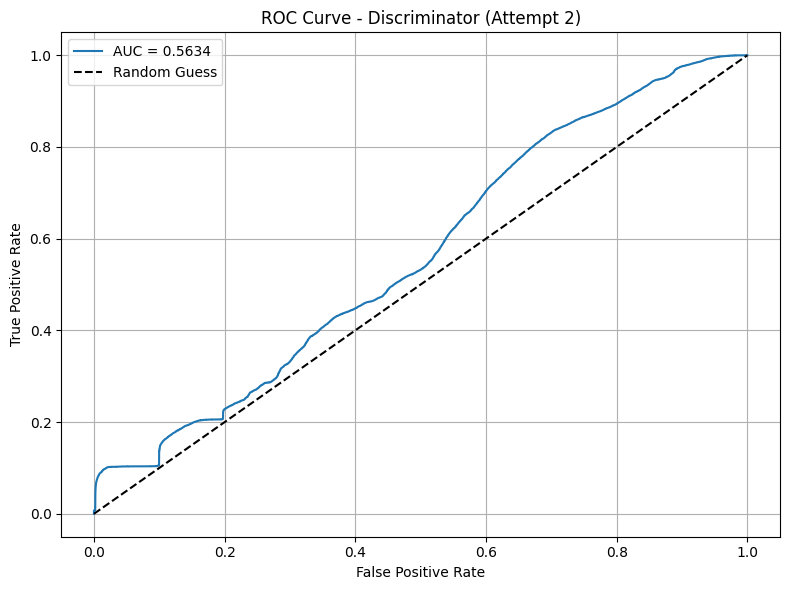

🧮 AUC Score (Attempt 2): 0.5634


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# === AUC-ROC Evaluation Function ===
def evaluate_auc_roc(G, D, X_real, y_real, noise_dim, num_classes, device):
    G.eval()
    D.eval()

    # Convert real data
    X_real_tensor = torch.tensor(X_real, dtype=torch.float32, device=device)
    y_real_tensor = torch.tensor(y_real, dtype=torch.long, device=device)
    y_onehot = F.one_hot(y_real_tensor, num_classes=num_classes).float().to(device)

    # Generate synthetic samples using the same labels
    z = torch.randn(len(X_real), noise_dim, device=device)
    X_fake_tensor = G(z, y_onehot)

    # Discriminator predictions
    with torch.no_grad():
        D_real = D(X_real_tensor, y_onehot).cpu().numpy().flatten()
        D_fake = D(X_fake_tensor, y_onehot).cpu().numpy().flatten()

    # Prepare labels and scores
    y_true = np.concatenate([np.ones_like(D_real), np.zeros_like(D_fake)])
    y_scores = np.concatenate([D_real, D_fake])

    # AUC Score
    auc = roc_auc_score(y_true, y_scores)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Discriminator (Attempt 2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"🧮 AUC Score (Attempt 2): {auc:.4f}")
    return auc

# === Run AUC-ROC Evaluation ===
# Ensure X and y (real data) are already defined, same as training data
auc_score = evaluate_auc_roc(G, D, X, y, noise_dim, num_classes, device)